# Comparing conventional and approximate Single-Output GPs training time and loss over number of samples

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

SMALL_SIZE = 13
MEDIUM_SIZE = 18
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

DIRECTORY_PATH = Path("temp/time_complexity")
DATA_FILE_PATH = Path(DIRECTORY_PATH, "single_time_over_sample_nb.csv")
PLOT_DIR_PATH = Path(DIRECTORY_PATH, "plots")

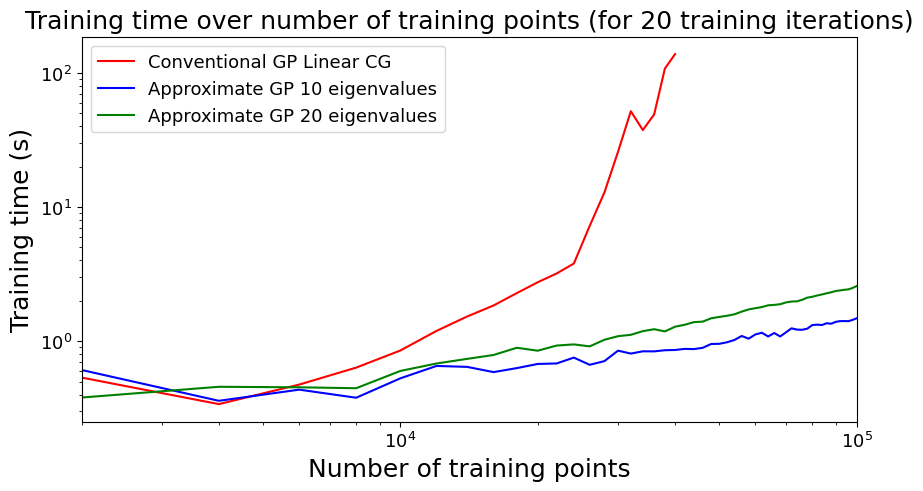

In [3]:
with open(DATA_FILE_PATH, "r", encoding="utf-8") as f:
    line_count = len(f.readlines()) - 1
    f.seek(0)
    headers = f.readline()  # discard headers

    sample_nbs = np.empty(line_count, dtype=int)
    train_t = np.empty((len(headers.split(",")[1:])//2, line_count), dtype=float)
    train_l = np.empty((len(headers.split(",")[1:])//2, line_count), dtype=float)
    col = 0
    while line := f.readline():
        data = line.split(',')
        sample_nbs[col] = data[0]

        for row, v in enumerate(data[1:]):
            if row % 2 == 0:
                train_t[row // 2, col] = v
            else:
                train_l[row // 2, col] = v

        col += 1

# plot results
f = plt.figure(figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)

# plot training time
plt.title("Training time over number of training points (for 20 training iterations)")
plt.xlabel("Number of training points")
plt.ylabel("Training time (s)")

plt.loglog(sample_nbs, train_t[0], 'r')
plt.loglog(sample_nbs, train_t[1], 'b')
plt.loglog(sample_nbs, train_t[2], 'g')

plt.xlim(x_min, x_max)
plt.legend(["Conventional GP Linear CG", "Approximate GP 10 eigenvalues", "Approximate GP 20 eigenvalues"])

path = Path(PLOT_DIR_PATH, "single_full.png")
if not path.parent.exists():
    path.parent.mkdir(parents=True)
plt.savefig(path)

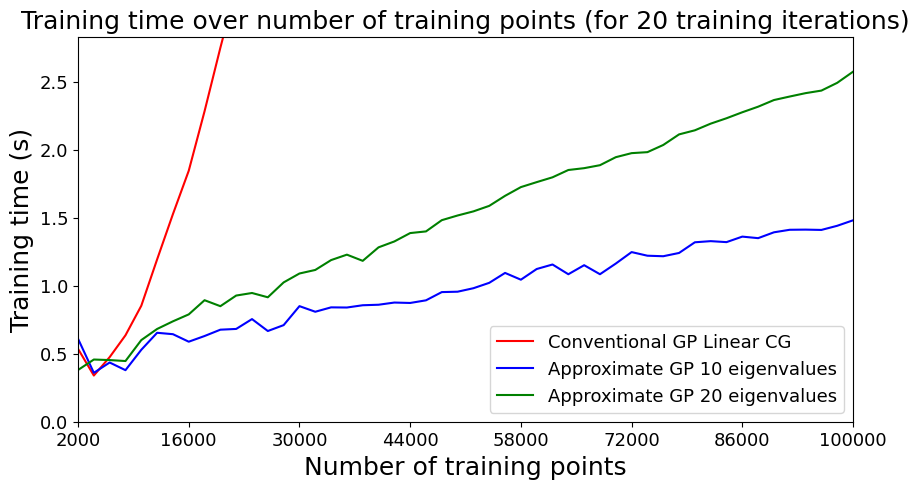

In [4]:
# plot results
f = plt.figure(figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = np.nanmax(train_t[2:])

# plot training time
plt.title("Training time over number of training points (for 20 training iterations)")
plt.xlabel("Number of training points")
plt.ylabel("Training time (s)")

plt.plot(sample_nbs, train_t[0], 'r')
plt.plot(sample_nbs, train_t[1], 'b')
plt.plot(sample_nbs, train_t[2], 'g')

plt.ylim(0, y_max + y_max / 10)
plt.xlim(x_min, x_max)
plt.xticks(np.arange(x_min, x_max + 1, 14000))
plt.legend(["Conventional GP Linear CG", "Approximate GP 10 eigenvalues", "Approximate GP 20 eigenvalues"])

plt.savefig(Path(PLOT_DIR_PATH, "single_approx.png"))

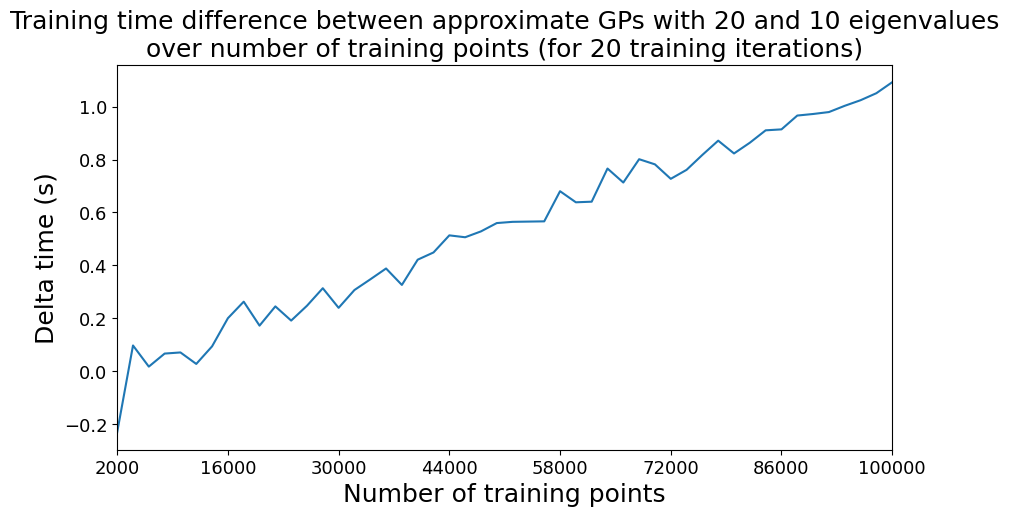

In [5]:
train_diff = train_t[2] - train_t[1]

f = plt.figure(figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = np.nanmax(train_diff)

plt.title("Training time difference between approximate GPs with 20 and 10 eigenvalues\nover number of training points (for 20 training iterations)")
plt.xlabel("Number of training points")
plt.ylabel("Delta time (s)")

plt.plot(sample_nbs, train_diff)

plt.xlim(x_min, x_max)
plt.xticks(np.arange(x_min, x_max + 1, 14000))

plt.savefig(Path(PLOT_DIR_PATH, "single_diff.png"))

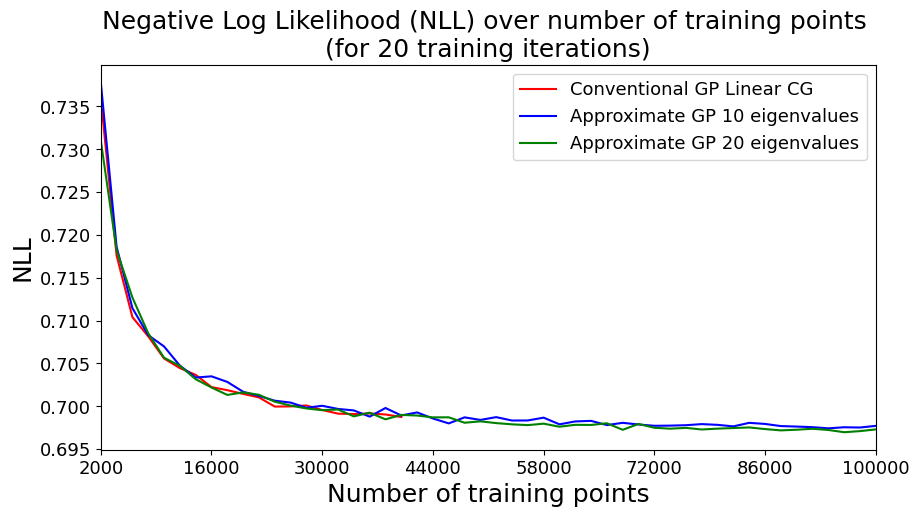

In [6]:
f = plt.figure(figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)

# plot loss
plt.title("Negative Log Likelihood (NLL) over number of training points \n(for 20 training iterations)")
plt.xlabel("Number of training points")
plt.ylabel("NLL")

plt.plot(sample_nbs, train_l[0], 'r')
plt.plot(sample_nbs, train_l[1], 'b')
plt.plot(sample_nbs, train_l[2], 'g')

plt.xlim(x_min, x_max)
plt.xticks(np.arange(x_min, x_max + 1, 14000))
plt.legend(["Conventional GP Linear CG", "Approximate GP 10 eigenvalues", "Approximate GP 20 eigenvalues"])

plt.savefig(Path(PLOT_DIR_PATH, "single_nll.png"))